In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, json
#from collections import Counter
import traceback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0, '/mnt/d/projects/bassline_transcription')
sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')

from dataset import *
from utilities import *
from plotting.dataset_plots import *
from representation import encode_midi_sequence, transpose_to_C
from bassline_transcriber.transcription import frequency_to_midi_sequence

In [2]:
directories = get_directories('../data/directories.json')
_, track_dicts, track_titles = read_metadata(directories, 'TechHouse_total_track_dicts.json')

## Midi Sequences Dataframe

In [3]:
silence_code=0
midi_sequences, valid_titles, keys, types = [], [], [], []
for title in track_titles:
    try:
        key, scale_type = track_dicts[title]['Key'].split(' ')
        pitch_track = load_quantized_pitch_track(title, directories)[1]
        midi_sequence = frequency_to_midi_sequence(pitch_track, silence_code=silence_code)
        midi_sequences.append(midi_sequence)
        valid_titles.append(title)
        keys.append(key)
        types.append(scale_type)
    except KeyboardInterrupt:
        sys.exit(0)  
    except FileNotFoundError:
        pass
    except Exception as ex:
        print(''.join(traceback.format_exception(etype=type(ex), value=ex, tb=ex.__traceback__)))
midi_sequences = np.array(midi_sequences).reshape(-1, 512)
print('There are {} midi sequences.'.format(midi_sequences.shape[0]))

There are 8896 midi sequences.


In [4]:
df = make_dataframe(midi_sequences, valid_titles, keys, types)
#df.to_csv('../data/metadata/midi_sequences.csv', index=False, header=False)

Original min: 23, max: 48
Transposed min: 13, max: 48


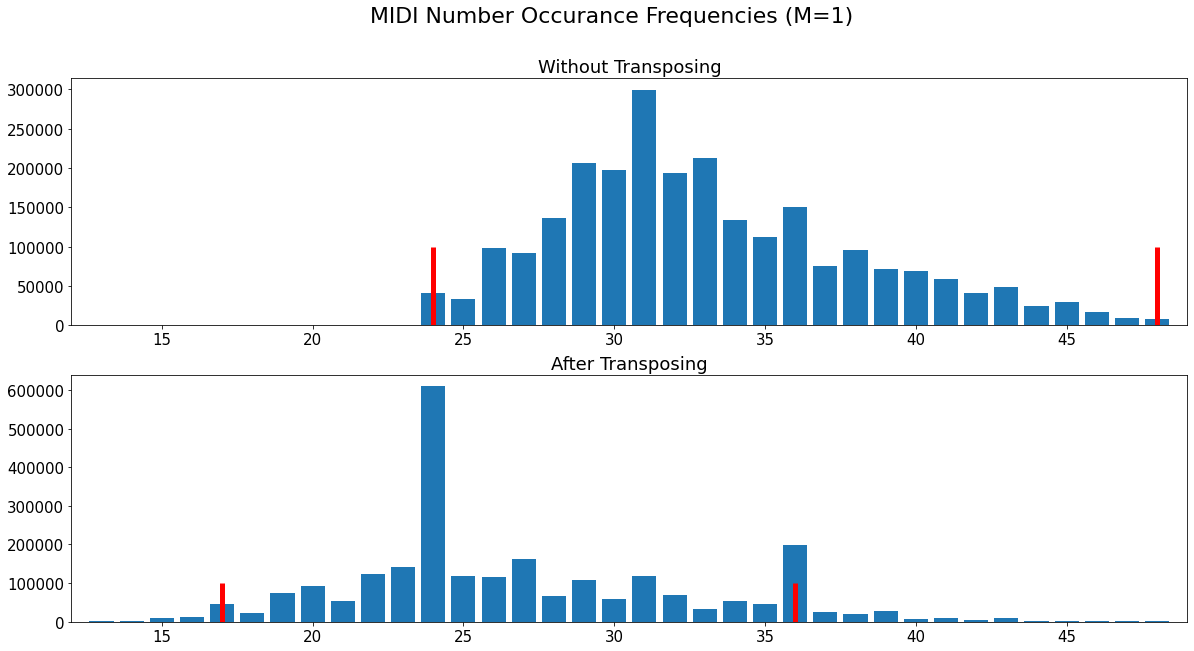

In [5]:
note_counter, note_counter_T = count_notes_with_transposing(df)
plot_note_occurances_with_transposing(note_counter, note_counter_T, 1)

## Encoding

In [6]:
with open('../data/metadata/bad_beat_f0_titles.txt', 'r') as infile:
    bad_titles = infile.read().split('\n')
print('There are {} tracks to exclude.'.format(len(bad_titles)))

There are 4420 tracks to exclude.


In [7]:
M=8
MIN_NOTE=16
MAX_NOTE=39
sustain_code=None
codes, titles, keys, scales = [], [], [], []
for title, key, scale, midi_sequence in zip(df['Title'], df['Key'], df['Scale'], df.iloc[:, 3:].to_numpy()):   
    try:  
        if title not in bad_titles:
            key = track_dicts[title]['Key'].split(' ')[0]
            code = encode_midi_sequence(midi_sequence, key, M, MIN_NOTE=MIN_NOTE,
                                        MAX_NOTE=MAX_NOTE, sustain_code=sustain_code) 
            if code is not None:
                codes.append(code)
                titles.append(title)
                keys.append(key)
                scales.append(scale)
    except KeyboardInterrupt:
        sys.exit(0)  
    except FileNotFoundError:
        pass
    except Exception as ex:
        print(''.join(traceback.format_exception(etype=type(ex), value=ex, tb=ex.__traceback__)))
codes = np.array(codes).reshape(-1,512//M)
df_codes = make_dataframe(codes, titles, keys, scales)
df_codes_min = df_codes[df_codes['Scale'] == "min"]
df_codes_maj = df_codes[df_codes['Scale'] == "maj"]
print('Number of total representations: {}\n'.format(df_codes.shape[0]))
print('Tokens:\n{}'.format(np.unique(df_codes.iloc[:, 3:].to_numpy())))
df_codes['Scale'].value_counts()

Number of total representations: 4542

Tokens:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


min    4055
maj     487
Name: Scale, dtype: int64

dataset_name = 'TechHouse_Bassline_Representations'
representation_path = os.path.join('..','data','datasets', 'new', '[{}, {}]'.format(MIN_NOTE,MAX_NOTE), 'sus')
os.makedirs(representation_path, exist_ok=True)

min_title = dataset_name+'_min_M{}.csv'.format(M)
maj_title = dataset_name+'_maj_M{}.csv'.format(M)
min_dir = os.path.join(representation_path, min_title)
maj_dir = os.path.join(representation_path, maj_title)
df_codes_min.to_csv(min_dir, index=False, header=False)
df_codes_maj.to_csv(maj_dir, index=False, header=False)

In [8]:
df_codes_min.iloc[:,3:].head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,9,9,9,9,4,4,7,0,9,...,4,7,0,9,9,9,9,4,4,7
1,0,0,0,0,0,15,0,0,0,15,...,15,15,15,0,15,16,15,15,15,16
2,0,0,0,0,24,0,0,12,12,0,...,12,12,12,12,0,12,12,12,12,12
3,0,10,0,0,0,12,0,10,9,9,...,0,0,10,10,0,12,0,9,0,12
4,0,0,0,20,20,0,14,21,21,14,...,14,21,20,14,16,22,22,16,16,16


Min: 0, max: 24


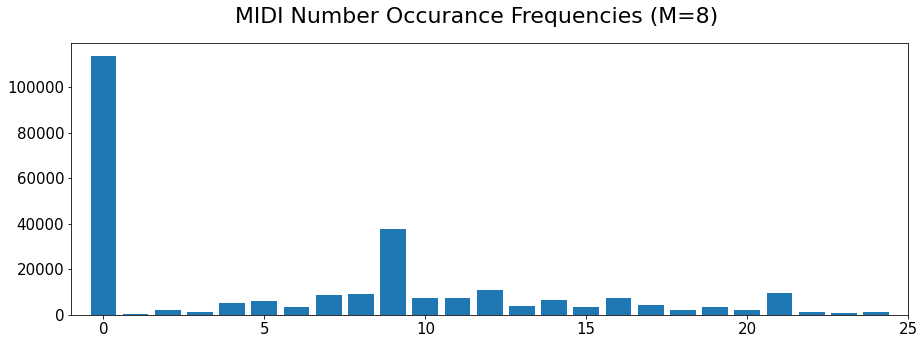

In [9]:
note_counter = count_notes(df_codes_min)
plot_note_occurances(note_counter, M)